<a href="https://colab.research.google.com/github/cbachen1997/CAUstudy/blob/master/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#挂载谷歌云盘
from google.colab import drive
drive.mount('/content/gdrive')
####google云盘授权#####
##每个notebook执行一次###
__author__='CBA'
from google.colab import drive

#增加PyDrive操作库
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#授权登录
auth.authenticate_user()
gauth=GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)

In [34]:
#更改运行目录
import os
os.chdir("/content/gdrive/My Drive/AndrewNgTest/SmileFaceReco")

In [6]:
#ResNet
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import resnets_utils 

In [11]:
def identity_block(X, f, filters, stage, block):
    """
    实现图3的恒等块
    
    参数：
        X - 输入的tensor类型的数据，维度为( m, n_H_prev, n_W_prev, n_H_prev )
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        
    返回：
        X - 恒等块的输出，tensor类型，维度为(n_H, n_W, n_C)
    
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器
    F1, F2, F3 = filters
    
    #保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X
    
    #主路径的第一部分
    ##卷积层
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1) ,padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    #主路径的第二部分
    ##卷积层
    X = Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    
    #主路径的第三部分
    ##卷积层
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    ##没有ReLU激活函数
    
    #最后一步：
    ##将捷径与输入加在一起
    X = Add()([X,X_shortcut])
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    return X

In [8]:
#残差块，维度发生改变，需要通过调节维度
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    实现图5的卷积块
    
    参数：
        X - 输入的tensor类型的变量，维度为( m, n_H_prev, n_W_prev, n_C_prev)
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        s - 整数，指定要使用的步幅
    
    返回：
        X - 卷积块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器数量
    F1, F2, F3 = filters#(64,64,256)
    
    #保存输入数据
    X_shortcut = X
    
    #主路径
    ##主路径第一部分
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)
    
    ##主路径第二部分
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    
    ##主路径第三部分
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    
    #捷径，1X1卷积修正维度
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+"1")(X_shortcut)
    
    #最后一步
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [12]:
#50层ResNet
def ResNet50(input_shape=(64,64,3),classes=6):
    """
    实现ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    
    参数：
        input_shape - 图像数据集的维度
        classes - 整数，分类数
        
    返回：
        model - Keras框架的模型
        
    """
    #定义tensor类型的输入数据
    X_input = Input(input_shape)
    #0填充变为(70,70,3)
    X = ZeroPadding2D((3,3))(X_input)
    #stage1
    #same卷积，
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), name="conv1",
               kernel_initializer=glorot_uniform(seed=0))(X)
    #（32，32，64）
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)
    #(16,16,64)

    #stage2,残差1次，恒等2次
    #残差块利用s大小降长宽
    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block="a", s=1)
    #(16,16,256)
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="c")

    #stage3
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block="a", s=2)
    #(8,8,512)
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="b")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="c")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="d")

    #stage4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block="a", s=2)
    #(4,4,1024)
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="b")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="c")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="d")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="e")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="f")

    #stage5
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block="a", s=2)
    #(2,2,2048)
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="c")
    
    #均值池化
    X = AveragePooling2D(pool_size=(2,2),padding="same")(X)
    #(2,2,2048)
    #矢量化
    X = Flatten()(X)
    #（4，2048）
    #全连接层classes=6，6个节点
    X = Dense(classes, activation="softmax", name="fc"+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    #创建模型
    model = Model(inputs=X_input, outputs=X, name="ResNet50")
    
    return model

In [13]:
model = ResNet50(input_shape=(64,64,3),classes=6)
#adam梯度下降，类别交叉熵损失函数，精度评价
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = resnets_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = resnets_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = resnets_utils.convert_to_one_hot(Y_test_orig, 6).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

In [31]:
#训练两代，batchsize=32
model.fit(X_train,Y_train,epochs=20,batch_size=32)

Train on 1080 samples
Epoch 1/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0648 - acc: 0.9778
Epoch 2/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0787 - acc: 0.9750
Epoch 3/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.1241 - acc: 0.9630
Epoch 4/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0909 - acc: 0.9731
Epoch 5/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0129 - acc: 0.9954
Epoch 6/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0807 - acc: 0.9815
Epoch 7/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0761 - acc: 0.9759
Epoch 8/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0484 - acc: 0.9815
Epoch 9/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0215 - acc: 0.9917
Epoch 10/20
1080/1080 [==============================] - 5s 4ms/sample - loss: 0.0590 -

In [32]:
preds = model.evaluate(X_test,Y_test)

print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

误差值 = 0.09918823540210724
准确率 = 0.96666664


my_image.shape = (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[0.9634057  0.01215955 0.00842678 0.00203334 0.01135314 0.00262139]]
识别结果为：0


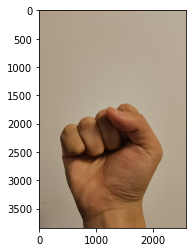

In [35]:
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片

%matplotlib inline

img_path = '0.jpg'

my_image = image.load_img(img_path, target_size=(64, 64))
my_image = image.img_to_array(my_image)

my_image = np.expand_dims(my_image,axis=0)
my_image = my_image/255

print("my_image.shape = " + str(my_image.shape))

print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(my_image))
print('识别结果为：'+ str(np.argmax(model.predict(my_image))))


my_image = mpimg.imread(img_path)
plt.imshow(my_image)